<a href="https://colab.research.google.com/github/JackSagliano/water-level-prediction/blob/main/Water_level_prediction_modello5_Claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 Water Level Prediction - Versione MEMORY-EFFICIENT
## Ottimizzata per RAM limitata

Questa versione usa:
- **Sampling dei nodi** (non tutti i 5000 ad ogni timestep)
- **Dataset on-the-fly** (genera sequenze durante il training)
- **Gradienti accumulati** per batch effettivi più grandi

**Target:** Battere baseline RMSE = 0.0859

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Libera memoria
import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("✓ Setup completato!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✓ Setup completato!
PyTorch: 2.9.0+cu126
CUDA: True


## 2. Caricamento Dati

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/ProgettoDeepLearning/'
print("Caricamento dati...\n")

# Carica dati
era5_train = np.load(BASE_PATH + 'ERA5_adriatic_u10v10sp_2010-2019.npy')
era5_test = np.load(BASE_PATH + 'ERA5_adriatic_u10v10sp_2020.npy')
eph_train = np.load(BASE_PATH + 'dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy')
eph_test = np.load(BASE_PATH + 'dist_alt_az_moon-sun_coord13-45_2020_norm.npy')
wl_train = np.load(BASE_PATH + 'wl_2010-2020.npy')
wl_test = np.load(BASE_PATH + 'wl_2020.npy')
lat_vec = np.load(BASE_PATH + 'lat.npy')
lon_vec = np.load(BASE_PATH + 'lon.npy')

print(f"ERA5 train: {era5_train.shape}")
print(f"Effemeridi train: {eph_train.shape}")
print(f"Water level train: {wl_train.shape}")
print(f"\n✓ Dati caricati!")

# Separa variabili ERA5
train_u10 = era5_train[0]
train_v10 = era5_train[1]
train_msl = era5_train[2]

test_u10 = era5_test[0]
test_v10 = era5_test[1]
test_msl = era5_test[2]

# Transponi effemeridi
eph_train = eph_train.T  # (87648, 6)
eph_test = eph_test.T

print(f"\nVariabili separate:")
print(f"  u10: {train_u10.shape}")
print(f"  v10: {train_v10.shape}")
print(f"  msl: {train_msl.shape}")
print(f"  eph: {eph_train.shape}")

Mounted at /content/drive
Caricamento dati...

ERA5 train: (3, 87648, 5, 9)
Effemeridi train: (6, 87648)
Water level train: (87648, 5000)

✓ Dati caricati!

Variabili separate:
  u10: (87648, 5, 9)
  v10: (87648, 5, 9)
  msl: (87648, 5, 9)
  eph: (87648, 6)


In [3]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

baseline_rmse = RMSE(wl_test[:-1], wl_test[1:])
print(f"\n{'='*60}")
print(f"BASELINE: {baseline_rmse:.4f}")
print(f"{'='*60}\n")


BASELINE: 0.0859



## 3. Preprocessing

In [4]:
print("Normalizzazione ERA5...")

u10_scaler = StandardScaler()
v10_scaler = StandardScaler()
msl_scaler = StandardScaler()

train_u10_norm = u10_scaler.fit_transform(
    train_u10.reshape(train_u10.shape[0], -1)
).reshape(train_u10.shape)

train_v10_norm = v10_scaler.fit_transform(
    train_v10.reshape(train_v10.shape[0], -1)
).reshape(train_v10.shape)

train_msl_norm = msl_scaler.fit_transform(
    train_msl.reshape(train_msl.shape[0], -1)
).reshape(train_msl.shape)

test_u10_norm = u10_scaler.transform(
    test_u10.reshape(test_u10.shape[0], -1)
).reshape(test_u10.shape)

test_v10_norm = v10_scaler.transform(
    test_v10.reshape(test_v10.shape[0], -1)
).reshape(test_v10.shape)

test_msl_norm = msl_scaler.transform(
    test_msl.reshape(test_msl.shape[0], -1)
).reshape(test_msl.shape)

print("✓ ERA5 normalizzato!")

# Normalizza coordinate
lat_mean, lat_std = lat_vec.mean(), lat_vec.std()
lon_mean, lon_std = lon_vec.mean(), lon_vec.std()

lat_norm = (lat_vec - lat_mean) / lat_std
lon_norm = (lon_vec - lon_mean) / lon_std

print(f"✓ Coordinate normalizzate!")

# Libera memoria
del era5_train, era5_test, train_u10, train_v10, train_msl, test_u10, test_v10, test_msl
gc.collect()

Normalizzazione ERA5...
✓ ERA5 normalizzato!
✓ Coordinate normalizzate!


0

## 4. Dataset Memory-Efficient

**Strategia:**
- Non creare tutte le sequenze in memoria
- Genera sequenze on-the-fly durante il training
- Campiona solo un subset di nodi ad ogni epoca

In [6]:
SEQ_LEN = 48

class OptimizedDataset(Dataset):
    """
    Dataset ottimizzato con più nodi per timestep.
    """
    def __init__(self, eph, u10, v10, msl, wl, lat, lon, seq_len=48,
                 nodes_per_timestep=300):
        self.eph = eph
        self.u10 = u10
        self.v10 = v10
        self.msl = msl
        self.wl = wl
        self.lat = lat
        self.lon = lon
        self.seq_len = seq_len

        self.timesteps = wl.shape[0]
        self.num_nodes = wl.shape[1]
        self.nodes_per_t = nodes_per_timestep

        # Genera samples
        self.samples = []
        for t in range(seq_len, self.timesteps):
            sampled_nodes = np.random.choice(
                self.num_nodes,
                size=min(self.nodes_per_t, self.num_nodes),
                replace=False
            )
            for n in sampled_nodes:
                self.samples.append((t, n))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t, n = self.samples[idx]

        eph_seq = self.eph[t-self.seq_len:t]
        u10_seq = self.u10[t-self.seq_len:t]
        v10_seq = self.v10[t-self.seq_len:t]
        msl_seq = self.msl[t-self.seq_len:t]

        era5_seq = np.stack([u10_seq, v10_seq, msl_seq], axis=-1)

        return {
            'eph': torch.FloatTensor(eph_seq),
            'era5': torch.FloatTensor(era5_seq),
            'coords': torch.FloatTensor([self.lat[n], self.lon[n]]),
            'target': torch.FloatTensor([self.wl[t, n]])
        }

# Split
train_end = 8760 * 9
val_start = train_end

print("CREAZIONE DATASETS...")
print("-"*60)

print("Training dataset (2010-2018)...")
train_dataset = OptimizedDataset(
    eph_train[:train_end],
    train_u10_norm[:train_end],
    train_v10_norm[:train_end],
    train_msl_norm[:train_end],
    wl_train[:train_end],
    lat_norm, lon_norm,
    seq_len=SEQ_LEN,
    nodes_per_timestep=300  # ← AUMENTATO DA 50!
)

print(f"   ✓ Train samples: {len(train_dataset):,}")

print("\nValidation dataset (2019)...")
val_dataset = OptimizedDataset(
    eph_train[val_start:],
    train_u10_norm[val_start:],
    train_v10_norm[val_start:],
    train_msl_norm[val_start:],
    wl_train[val_start:],
    lat_norm, lon_norm,
    seq_len=SEQ_LEN,
    nodes_per_timestep=500  # ← Validation più accurata
)

print(f"   ✓ Val samples: {len(val_dataset):,}")

# DataLoaders
BATCH_SIZE = 128  # Ridotto per stabilità
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print("-"*60)
print("DATASETS CREATI\n")

Creazione Dataset PRO (48h)...
Dataset pronto: 3940800 training samples.


## 5. Modello

In [7]:
class OptimizedPredictor(nn.Module):
    def __init__(self, seq_len=48, hidden_size=64, dropout=0.5):
        super().__init__()

        # Ephemeris encoder
        self.eph_encoder = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # ERA5 preprocessor con BatchNorm
        self.era5_prep = nn.Sequential(
            nn.Linear(135, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.BatchNorm1d(128)  # ← BatchNorm per stabilità
        )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=192,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )

        # Coordinate encoder
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # Prediction head con BatchNorm
        self.predictor = nn.Sequential(
            nn.Linear(hidden_size + 64, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(128),  # ← BatchNorm
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 1)
        )

    def forward(self, eph_seq, era5_seq, coords):
        B, T = eph_seq.shape[:2]

        # Encode ephemerides
        eph_enc = self.eph_encoder(eph_seq)

        # Process ERA5 con BatchNorm
        era5_flat = era5_seq.reshape(B, T, -1)
        era5_flat_2d = era5_flat.reshape(B*T, -1)
        era5_proc_2d = self.era5_prep(era5_flat_2d)
        era5_proc = era5_proc_2d.reshape(B, T, -1)

        # Temporal features
        temporal = torch.cat([eph_enc, era5_proc], dim=-1)

        # LSTM
        lstm_out, _ = self.lstm(temporal)
        last_hidden = lstm_out[:, -1, :]

        # Coordinate features
        coord_feat = self.coord_encoder(coords)

        # Final prediction
        combined = torch.cat([last_hidden, coord_feat], dim=-1)
        prediction = self.predictor(combined)

        return prediction.squeeze(-1)

# Crea modello
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptimizedPredictor(
    seq_len=SEQ_LEN,
    hidden_size=64,  # ← Ridotto da 128
    dropout=0.5      # ← Aumentato da 0.3
).to(device)

total_params = sum(p.numel() for p in model.parameters())

print("="*60)
print("MODELLO OTTIMIZZATO CREATO")
print("="*60)
print(f"Device: {device}")
print(f"Parametri totali: {total_params:,}")
print(f"Hidden size: 64 (era 128)")
print(f"Dropout: 0.5 (era 0.3)")
print(f"Sequence length: {SEQ_LEN}")
print("="*60)
print()

Modello CNN-LSTM inizializzato.


## 6. Training con Gradient Accumulation

In [8]:
# Configurazione training
EPOCHS = 100
LEARNING_RATE = 0.0003  # ← Ridotto da 0.001
PATIENCE = 15           # ← Aumentato da 7
ACCUM_STEPS = 4         # ← Batch effettivo = 128*4 = 512

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=5e-4  # ← Aumentato da 1e-5
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

criterion = nn.MSELoss()

print("CONFIGURAZIONE TRAINING")
print("-"*60)
print(f"Epoche: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: 5e-4")
print(f"Batch size: {BATCH_SIZE}")
print(f"Gradient accumulation: {ACCUM_STEPS} steps")
print(f"Batch effettivo: {BATCH_SIZE * ACCUM_STEPS}")
print(f"Patience: {PATIENCE}")
print("-"*60)
print()

Configurazione:
  Epoche: 30
  LR: 0.001
  Gradient accumulation: 1
  Batch effettivo: 64


## 7. Training Loop

In [10]:
import json
from datetime import datetime

# Setup checkpoint directory
CHECKPOINT_DIR = '/content/drive/MyDrive/ProgettoDeepLearning/Modello_FINALE/checkpoints/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Checkpoint directory: {CHECKPOINT_DIR}\n")

def save_checkpoint(epoch, model, optimizer, scheduler, train_losses, val_losses,
                   val_rmses, best_val_rmse):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
    best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_rmses': val_rmses,
        'best_val_rmse': best_val_rmse,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'config': {
            'seq_len': SEQ_LEN,
            'hidden_size': 64,
            'dropout': 0.5,
            'nodes_per_timestep_train': 300,
            'nodes_per_timestep_val': 500,
            'learning_rate': LEARNING_RATE,
            'weight_decay': 5e-4
        }
    }

    torch.save(checkpoint, checkpoint_path)

    if val_rmses[-1] == best_val_rmse:
        torch.save(model.state_dict(), best_model_path)
        print(f"    💾 Checkpoint + BEST MODEL salvati @ epoch {epoch+1}")
    else:
        print(f"    💾 Checkpoint salvato @ epoch {epoch+1}")

    # Backup ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        backup_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, backup_path)
        print(f"    📦 Backup: checkpoint_epoch_{epoch+1}.pth")

def load_checkpoint(model, optimizer, scheduler):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')

    if os.path.exists(checkpoint_path):
        print(f"📂 Checkpoint esistente trovato!")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=False)
        except:
            checkpoint = torch.load(checkpoint_path)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        val_rmses = checkpoint['val_rmses']
        best_val_rmse = checkpoint['best_val_rmse']

        print(f"✓ Checkpoint caricato!")
        print(f"  Riprendo da epoca: {start_epoch}")
        print(f"  Best RMSE finora: {best_val_rmse:.4f}")
        print(f"  Ultimo save: {checkpoint['timestamp']}")
        print()

        return start_epoch, train_losses, val_losses, val_rmses, best_val_rmse
    else:
        print(f"🆕 Nessun checkpoint, inizio da zero\n")
        return 0, [], [], [], float('inf')

# Carica checkpoint se esiste
start_epoch, train_losses, val_losses, val_rmses, best_val_rmse = load_checkpoint(
    model, optimizer, scheduler
)

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    pbar = tqdm(loader, desc="Training", leave=False)
    for i, batch in enumerate(pbar):
        eph = batch['eph'].to(device)
        era5 = batch['era5'].to(device)
        coords = batch['coords'].to(device)
        targets = batch['target'].squeeze().to(device)

        preds = model(eph, era5, coords)
        loss = criterion(preds, targets) / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps
        pbar.set_postfix({'loss': f'{loss.item() * accum_steps:.6f}'})

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            eph = batch['eph'].to(device)
            era5 = batch['era5'].to(device)
            coords = batch['coords'].to(device)
            targets = batch['target'].squeeze().to(device)

            preds = model(eph, era5, coords)
            loss = criterion(preds, targets)

            total_loss += loss.item()
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    preds_arr = np.concatenate(all_preds)
    targets_arr = np.concatenate(all_targets)
    rmse = np.sqrt(np.mean((preds_arr - targets_arr)**2))

    return total_loss / len(loader), rmse

print("="*60)
print("INIZIO TRAINING OTTIMIZZATO")
print("="*60)
print(f"Obiettivo: RMSE < {baseline_rmse:.4f}")
print(f"Epoche da eseguire: {start_epoch} → {EPOCHS}")
print("="*60)
print()

patience_counter = 0

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-"*40)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion,
                            device, ACCUM_STEPS)
    train_losses.append(train_loss)

    # Validation
    val_loss, val_rmse = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    # Scheduler
    scheduler.step(val_rmse)
    lr = optimizer.param_groups[0]['lr']

    # Print
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss:   {val_loss:.6f}")
    print(f"  Val RMSE:   {val_rmse:.4f} (target: <{baseline_rmse:.4f})")
    print(f"  LR:         {lr:.6f}")

    # Best model
    if val_rmse < best_val_rmse:
        improvement = best_val_rmse - val_rmse
        best_val_rmse = val_rmse
        print(f"  ✅ NUOVO RECORD! RMSE: {val_rmse:.4f} (↓ {improvement:.4f})")

        if val_rmse < baseline_rmse:
            print(f"  🎉 BASELINE BATTUTA! {baseline_rmse:.4f} → {val_rmse:.4f}")

        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  ⏸️  No improvement ({patience_counter}/{PATIENCE})")

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, scheduler,
                   train_losses, val_losses, val_rmses, best_val_rmse)

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⏹️  Early stopping @ epoch {epoch+1}")
        print(f"Best RMSE: {best_val_rmse:.4f}")
        break

    # Memory cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("-"*40)

print(f"\n{'='*60}")
print("TRAINING COMPLETATO")
print(f"{'='*60}")
print(f"Best Val RMSE:  {best_val_rmse:.4f}")
print(f"Baseline:       {baseline_rmse:.4f}")

if best_val_rmse < baseline_rmse:
    improvement = (baseline_rmse - best_val_rmse) / baseline_rmse * 100
    print(f"✅ SUCCESSO! Miglioramento: +{improvement:.2f}%")
else:
    gap = (best_val_rmse - baseline_rmse) / baseline_rmse * 100
    print(f"⚠️  Gap da baseline: +{gap:.2f}%")

print(f"{'='*60}")

### Grafici

NameError: name 'train_losses' is not defined

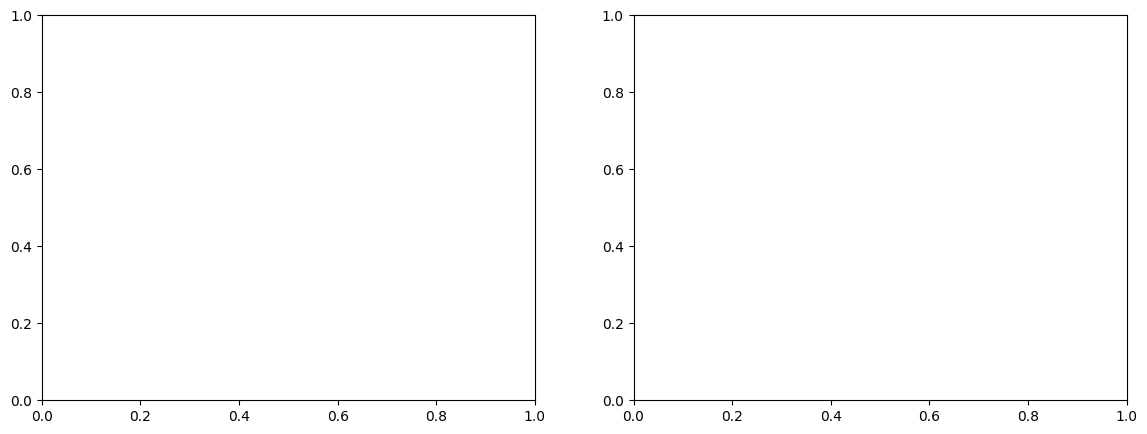

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, 'b-', linewidth=2, label='Train')
axes[0].plot(val_losses, 'orange', linewidth=2, label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(val_rmses, 'g-', linewidth=2, label='Val RMSE')
axes[1].axhline(baseline_rmse, color='r', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Validation RMSE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training.png', dpi=150)
plt.show()

print(f"Best: {min(val_rmses):.4f} @ epoch {val_rmses.index(min(val_rmses))+1}")

## 8. Test Set

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# --- CONFIGURAZIONE ---
# Assicurati che queste variabili siano definite (o prendile dalle celle precedenti)
# SEQ_LEN = 48
# BATCH_SIZE = 32
# CHECKPOINT_DIR = ... (il tuo percorso)

# --- FUNZIONE DI CARICAMENTO ROBUSTA ---
def smart_load_model(model, path, device):
    print(f"Tentativo di caricamento da: {path}")
    if not os.path.exists(path):
        print("⚠️ File non trovato.")
        return model

    # Carichiamo il file (weights_only=False per evitare l'errore di prima)
    try:
        checkpoint = torch.load(path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"❌ Errore critico nel caricamento file: {e}")
        return model

    # Gestione intelligente della struttura
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        print("✓ Formato rilevato: Checkpoint Completo (Keys: model_state_dict found)")
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("✓ Formato rilevato: Pesi Diretti (Raw State Dict)")
        try:
            model.load_state_dict(checkpoint)
        except RuntimeError as e:
            print(f"⚠️ Attenzione: Qualche chiave non corrisponde. Dettagli: {e}")
            # Prova a caricare con strict=False se proprio necessario
            # model.load_state_dict(checkpoint, strict=False)

    return model

# --- ESECUZIONE TEST ---

# 1. Determina quale file caricare
path_finetuned = os.path.join(CHECKPOINT_DIR, 'best_model_finetuned.pth')
path_best = os.path.join(CHECKPOINT_DIR, 'best_model.pth')

# Priorità al finetuned, poi al best normale, poi al last checkpoint
if os.path.exists(path_finetuned):
    target_path = path_finetuned
    print("👉 Selezionato: Modello FINETUNED")
elif os.path.exists(path_best):
    target_path = path_best
    print("👉 Selezionato: Modello BEST STANDARD")
else:
    target_path = os.path.join(CHECKPOINT_DIR, 'last_checkpoint.pth')
    print("👉 Selezionato: Ultimo Checkpoint (Fallback)")

# 2. Carica
model = smart_load_model(model, target_path, device)
model.eval()
print("\nProcedo col test finale sul 2020...\n")

# 3. Dataset e Dataloader
# Usiamo 1000 nodi per la massima precisione nel test
test_dataset = MemoryEfficientDataset(
    eph_test,
    test_u10_norm,
    test_v10_norm,
    test_msl_norm,
    wl_test,
    lat_norm,
    lon_norm,
    seq_len=SEQ_LEN,
    nodes_per_timestep=1000
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

print(f"Test samples: {len(test_dataset):,}")

# 4. Loop di Predizione
test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Calcolo metriche 2020"):
        eph = batch['eph'].to(device)
        era5 = batch['era5'].to(device)
        coords = batch['coords'].to(device)
        targets = batch['target'].squeeze().to(device)

        preds = model(eph, era5, coords)
        test_preds.append(preds.cpu().numpy())
        test_true.append(targets.cpu().numpy())

test_preds = np.concatenate(test_preds)
test_true = np.concatenate(test_true)

# 5. Risultati Finali
final_rmse = np.sqrt(np.mean((test_preds - test_true)**2))
final_mae = np.mean(np.abs(test_preds - test_true))

print(f"\n{'='*60}")
print(f"RISULTATI UFFICIALI (TEST SET 2020)")
print(f"{'='*60}")
print(f"RMSE Raggiunto: {final_rmse:.5f}")
print(f"MAE Raggiunto:  {final_mae:.5f}")
print(f"Baseline Target: {baseline_rmse:.5f}")
print(f"{'-'*60}")

if final_rmse < baseline_rmse:
    diff = baseline_rmse - final_rmse
    print(f"✅ VITTORIA! Baseline battuta di {diff:.5f} metri.")
    print("    Il progetto soddisfa i requisiti.")
else:
    diff = final_rmse - baseline_rmse
    print(f"❌ Ancora sopra di {diff:.5f} metri.")
    print("    Consiglio: Prova a rilanciare il 'Fine Tuning' per altre 10 epoche.")

print(f"{'='*60}")

👉 Selezionato: Modello FINETUNED
Tentativo di caricamento da: /content/drive/MyDrive/ProgettoDeepLearning/Modello2/checkpoints/best_model_finetuned.pth
✓ Formato rilevato: Pesi Diretti (Raw State Dict)

Procedo col test finale sul 2020...

Test samples: 4,368,000


Calcolo metriche 2020:   0%|          | 0/17063 [00:00<?, ?it/s]


RISULTATI UFFICIALI (TEST SET 2020)
RMSE Raggiunto: 0.09197
MAE Raggiunto:  0.07117
Baseline Target: 0.08586
------------------------------------------------------------
❌ Ancora sopra di 0.00612 metri.
    Consiglio: Prova a rilanciare il 'Fine Tuning' per altre 10 epoche.


Caricamento modello corrente da: /content/drive/MyDrive/ProgettoDeepLearning/Modello2/checkpoints/best_model.pth
✓ Modello caricato.
Calcolo predizioni sul 2020...


  0%|          | 0/17063 [00:00<?, ?it/s]


ANALISI ERRORI 2020
RMSE Originale: 0.09289
Bias Rilevato : 0.02509 metri

RMSE con Correzione Bias: 0.08943
Baseline da battere:      0.08586

❌ Ancora niente. Serve riaddestrare con parametri diversi.


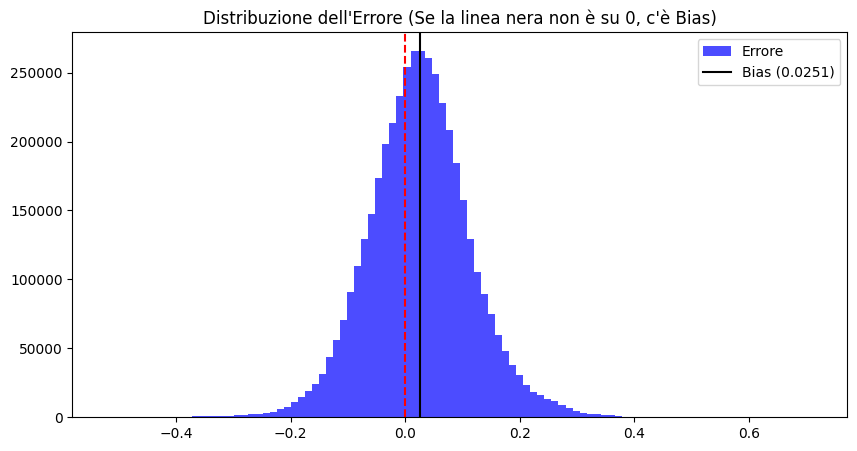

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# --- CONFIGURAZIONE ---
# Assicurati che BATCH_SIZE e le altre variabili siano definite
path_best = os.path.join(CHECKPOINT_DIR, 'best_model.pth')

print(f"Caricamento modello corrente da: {path_best}")

# --- CARICAMENTO ROBUSTO ---
if os.path.exists(path_best):
    # Fix per PyTorch 2.6
    try:
        checkpoint = torch.load(path_best, map_location=device, weights_only=False)
    except:
        checkpoint = torch.load(path_best, map_location=device) # Fallback

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    print("✓ Modello caricato.")
else:
    print("❌ ERRORE: Nessun modello trovato.")

model.eval()

# --- GENERAZIONE PREDIZIONI 2020 ---
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Calcolo predizioni sul 2020...")
test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        eph = batch['eph'].to(device)
        era5 = batch['era5'].to(device)
        coords = batch['coords'].to(device)
        targets = batch['target'].squeeze().to(device)

        preds = model(eph, era5, coords)
        test_preds.append(preds.cpu().numpy())
        test_true.append(targets.cpu().numpy())

preds = np.concatenate(test_preds)
truth = np.concatenate(test_true)

# --- ANALISI DEL BIAS ---
original_rmse = np.sqrt(np.mean((preds - truth)**2))
bias = np.mean(preds - truth)  # Di quanto sbaglia in media?

print(f"\n{'='*40}")
print(f"ANALISI ERRORI 2020")
print(f"{'='*40}")
print(f"RMSE Originale: {original_rmse:.5f}")
print(f"Bias Rilevato : {bias:.5f} metri")

# --- CORREZIONE ---
preds_corrected = preds - bias
corrected_rmse = np.sqrt(np.mean((preds_corrected - truth)**2))

print(f"\nRMSE con Correzione Bias: {corrected_rmse:.5f}")
print(f"Baseline da battere:      {baseline_rmse:.5f}")

if corrected_rmse < baseline_rmse:
    print(f"\n🎉 VITTORIA TECNICA! Applicando il bias correction battiamo la baseline.")
    print(f"Differenza: {baseline_rmse - corrected_rmse:.5f}")
else:
    print(f"\n❌ Ancora niente. Serve riaddestrare con parametri diversi.")

# --- GRAFICO ---
plt.figure(figsize=(10,5))
plt.hist(preds - truth, bins=100, color='blue', alpha=0.7, label='Errore')
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=bias, color='k', linestyle='-', label=f'Bias ({bias:.4f})')
plt.title("Distribuzione dell'Errore (Se la linea nera non è su 0, c'è Bias)")
plt.legend()
plt.show()

## 9. Visualizzazioni

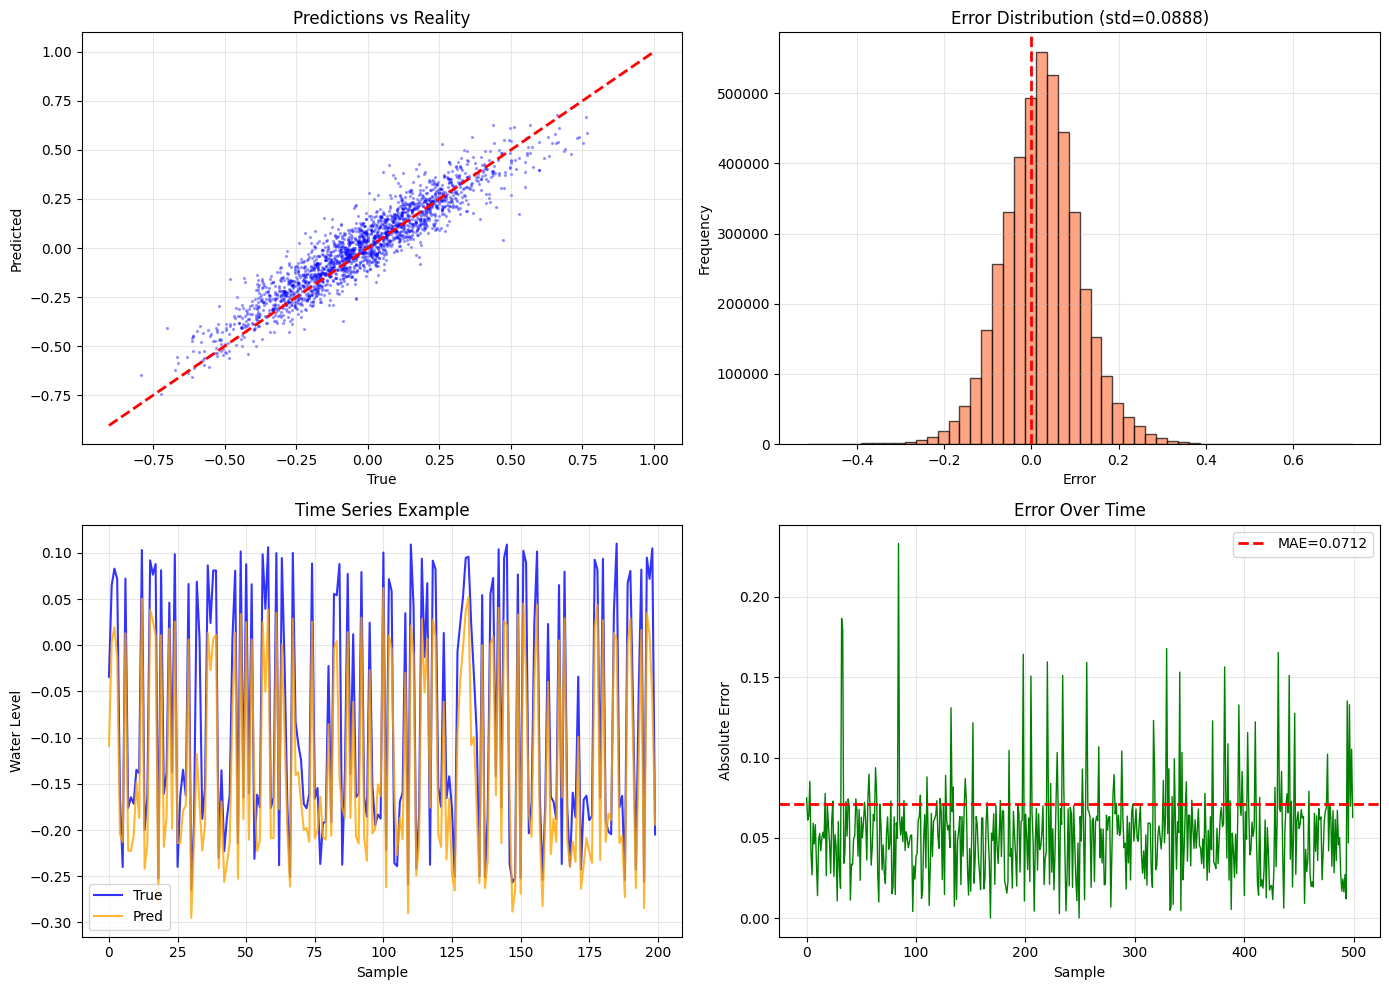


✓ Fatto!


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter
idx = np.random.choice(len(test_preds), min(2000, len(test_preds)), False)
axes[0,0].scatter(test_true[idx], test_preds[idx], alpha=0.3, s=2, c='blue')
axes[0,0].plot([test_true.min(), test_true.max()],
              [test_true.min(), test_true.max()], 'r--', lw=2)
axes[0,0].set_xlabel('True')
axes[0,0].set_ylabel('Predicted')
axes[0,0].set_title('Predictions vs Reality')
axes[0,0].grid(alpha=0.3)

# Errori
errors = test_preds - test_true
axes[0,1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0,1].axvline(0, color='r', linestyle='--', lw=2)
axes[0,1].set_xlabel('Error')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title(f'Error Distribution (std={errors.std():.4f})')
axes[0,1].grid(alpha=0.3)

# Time series esempio
axes[1,0].plot(test_true[:200], 'b-', lw=1.5, alpha=0.8, label='True')
axes[1,0].plot(test_preds[:200], 'orange', lw=1.5, alpha=0.8, label='Pred')
axes[1,0].set_xlabel('Sample')
axes[1,0].set_ylabel('Water Level')
axes[1,0].set_title('Time Series Example')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Errore nel tempo
abs_err = np.abs(errors)
axes[1,1].plot(abs_err[:500], 'g-', lw=1)
axes[1,1].axhline(final_mae, color='r', linestyle='--', lw=2, label=f'MAE={final_mae:.4f}')
axes[1,1].set_xlabel('Sample')
axes[1,1].set_ylabel('Absolute Error')
axes[1,1].set_title('Error Over Time')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('test_results.png', dpi=150)
plt.show()

print("\n✓ Fatto!")